In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
plt.rcParams['axes.grid'] = True

In [2]:
# Load data
fs = 256000
sig = np.load( "data/fmStation.256ksps.5secs.npy")

Text(0.5, 1.0, 'Waveforms')

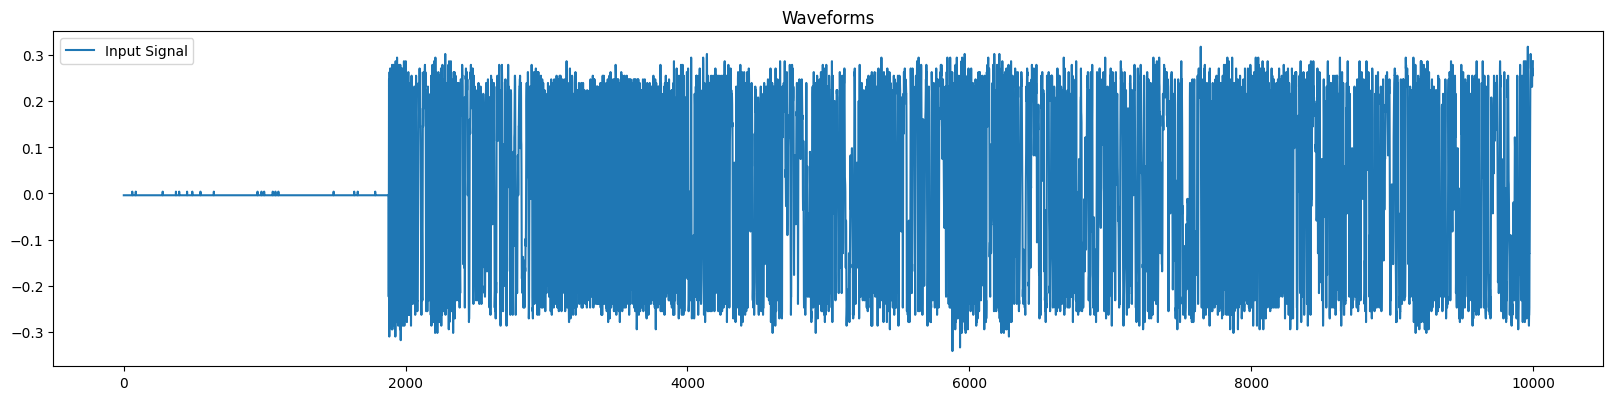

In [3]:
"""
Interesting that we see some leading dead time
"""

# Create a Figure
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

# Set up Axes
ax1 = fig.add_subplot(411)
ax1.plot(sig.real[:10000], label='Input Signal')
plt.grid()
plt.legend()
ax1.set_title('Waveforms')

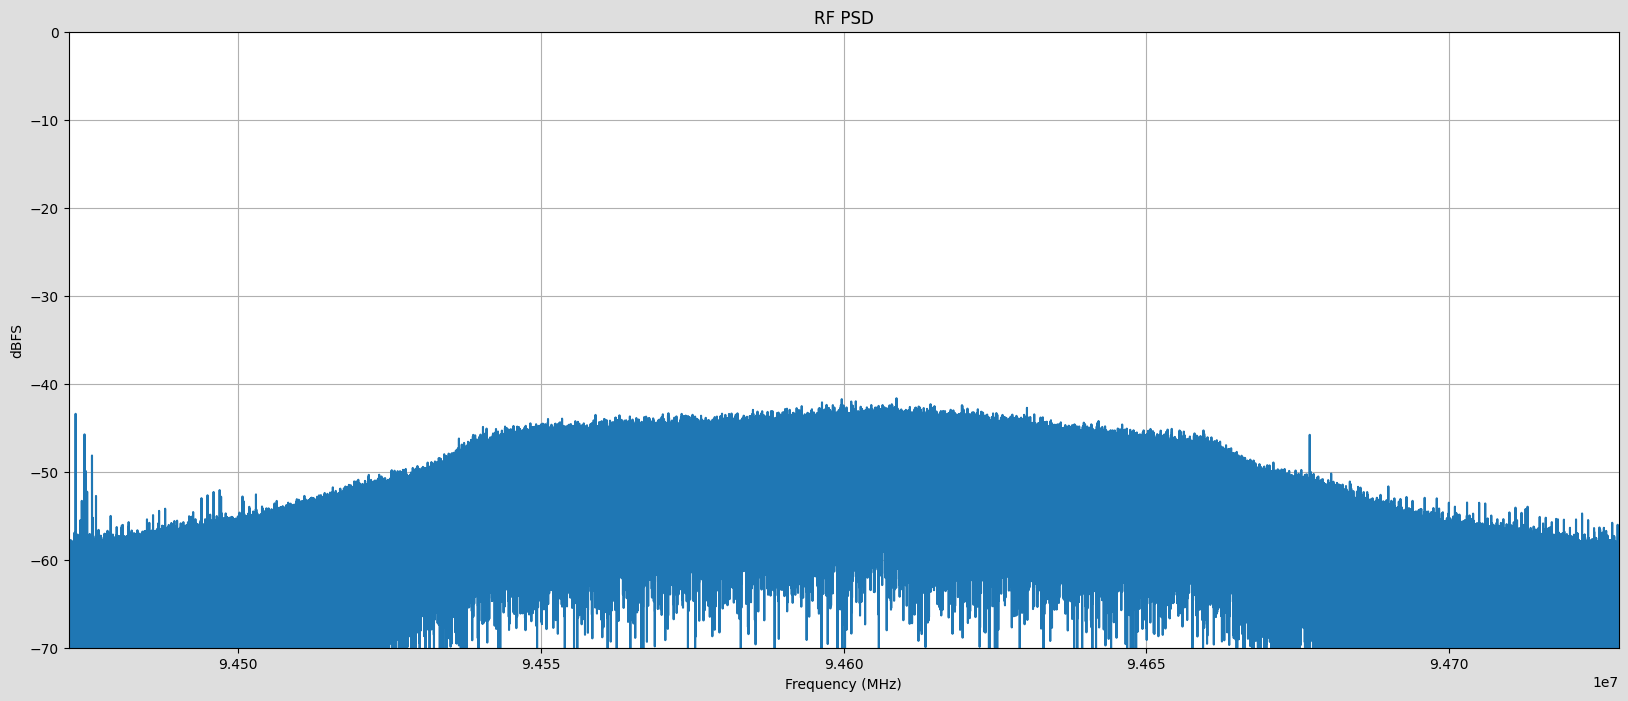

In [4]:
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
import numpy as np

from scipy.signal import resample

def doComplexPsd( psdAx, centerFreq, fullscale, sampleRate, samples ):
    N = len(samples)
    nBins = N
    T = 1/sampleRate

    yf = fft(samples)

    # yf = resample( yf, self.nBins )
    xf = fftfreq(nBins, T) # Convenience function, Returns the frequency bin center freqs

    xf = fftshift(xf) # Convenience function, swaps the bins so that they can be directly plotted (Recall FFT output is kinda wonky pre-shift)
    yplot = fftshift(yf) # Have to shift the actual fft values too
    yplot = 1.0/N * np.abs(yplot) # Normalize the magnitude of FFT

    # Put in terms of dBFS
    yplot = 10*np.log10(yplot/fullscale)

    x_axis = (centerFreq - sampleRate/2, centerFreq + sampleRate/2)
    psdAx.plot(xf+centerFreq, yplot)
    psdAx.set_xlabel('Frequency (MHz)')
    psdAx.set_ylabel('dBFS')
    psdAx.set_ylim(-70, 0)
    psdAx.set_xlim(x_axis[0], x_axis[1])
        

sample_rate = 256000
center_freq = 94.6e6
fullscale = math.sqrt(2**8 + 2**8)
nBins = 1310720

fig, axes = plt.subplots( nrows=1, ncols=1, sharex=False, figsize=(20,8), facecolor='#DEDEDE' )

rfPsdAx = axes
rfPsdAx.set_title( "RF PSD" )

doComplexPsd( rfPsdAx, center_freq, fullscale, fs, sig )



"\nIt's interesting that there's essentially no difference between demod_resampled and demod_filtered_resampled\nI suspect resample is doing some serious filtering, because injecting a ludicrously powerful interferer does not show\nup as an alias _AT ALL_, when it shows up even after being filtered in demod_filtered\n"

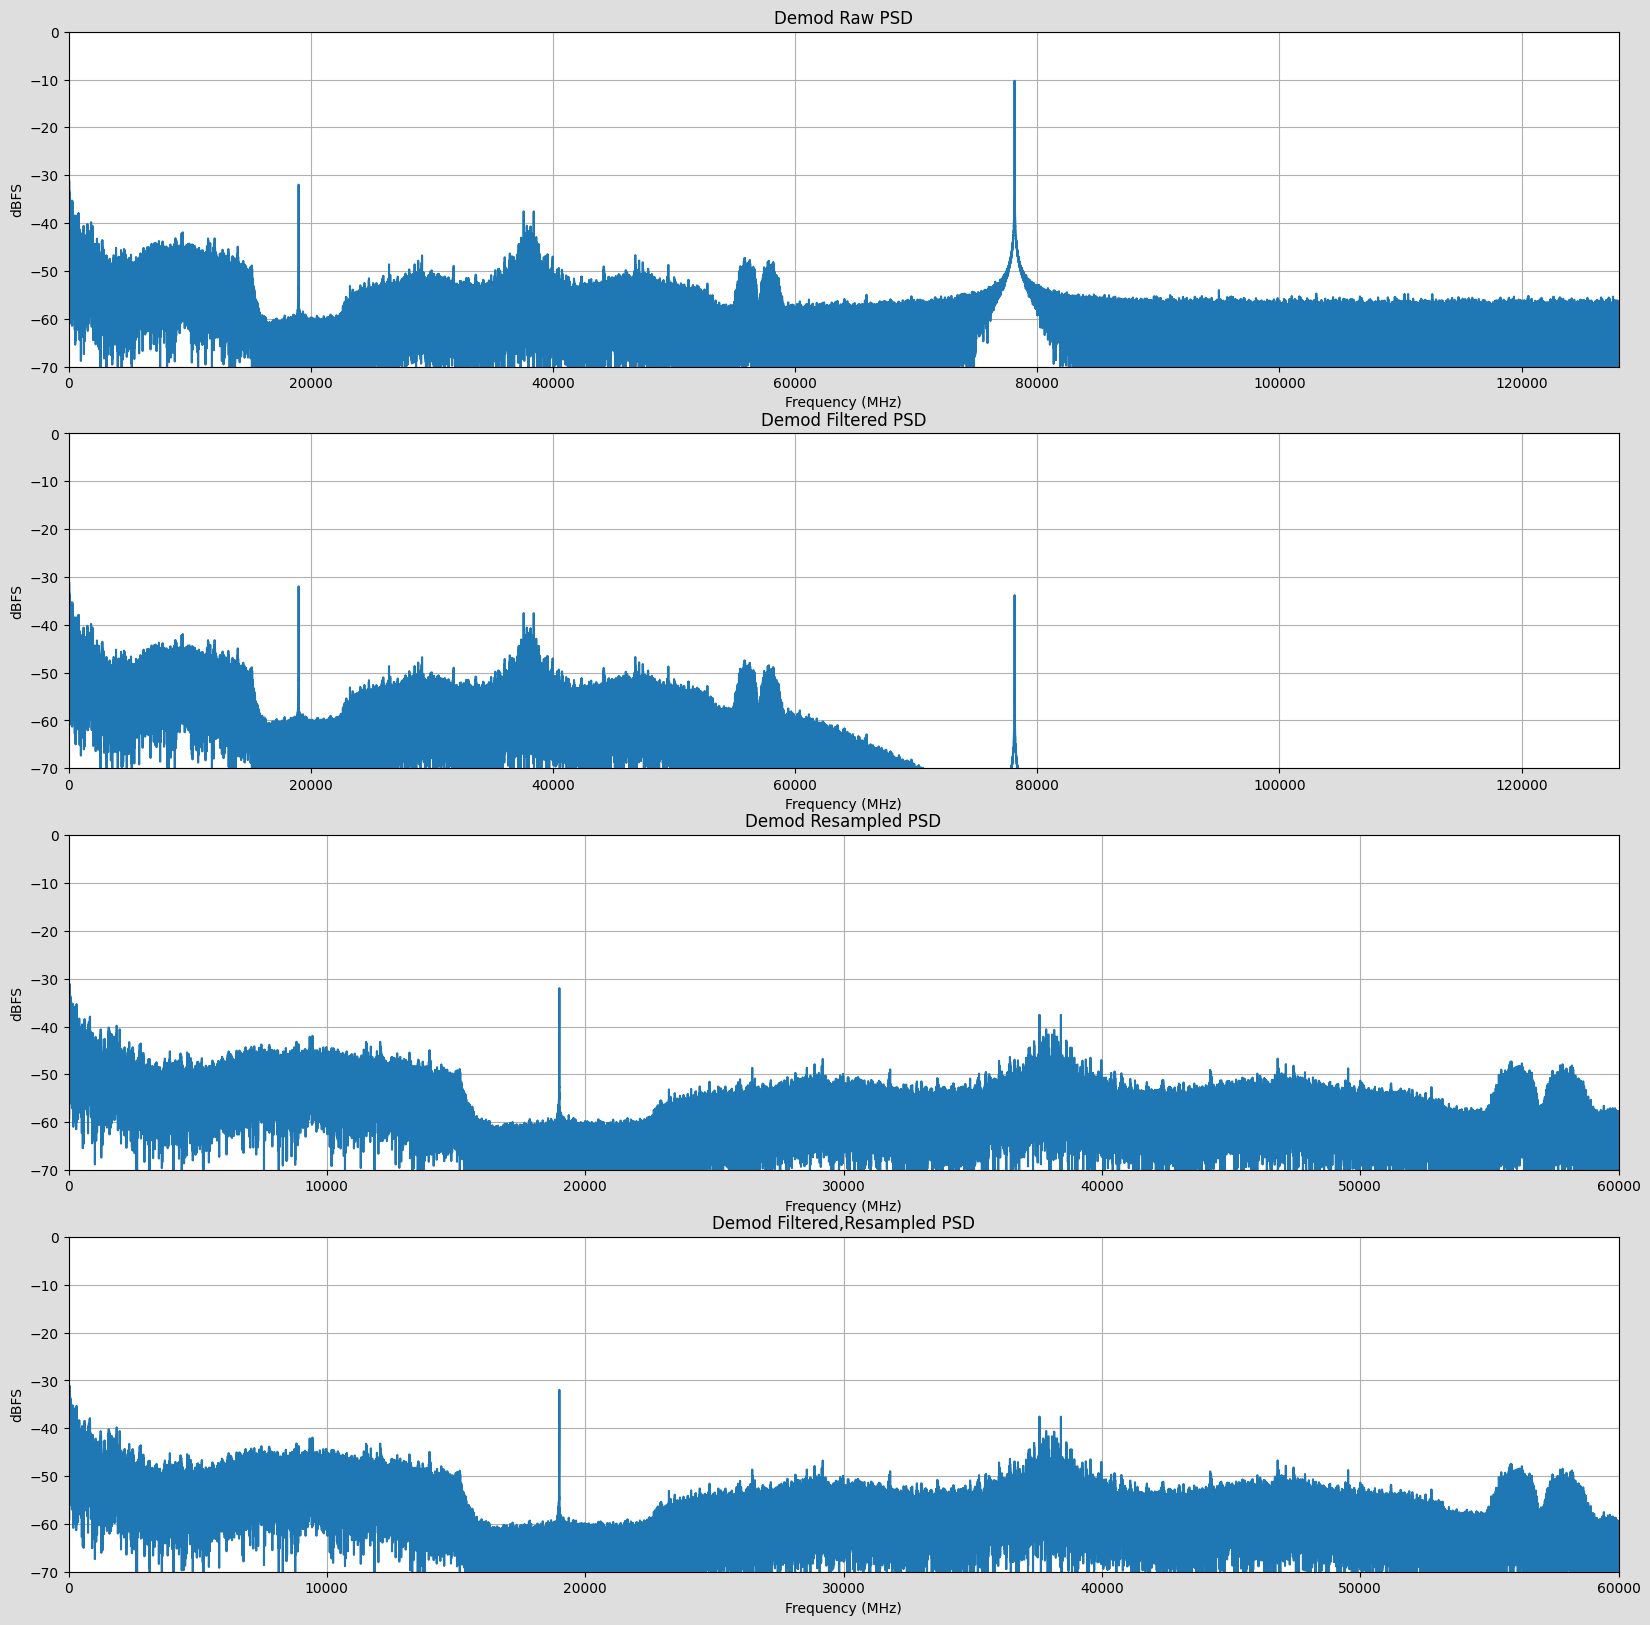

In [5]:
# Demodulate that shit!
# See comments at bottom

from scipy.signal import resample
from scipy.signal import butter, lfilter, freqz


def build_butter_filter(cutoff, fs, order=24):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def build_butter_bandpass_filter(start, stop, fs, order=24):
    nyq = 0.5 * fs
    start = start / nyq
    stop = stop / nyq
    b, a = butter(order, (start,stop), btype='bandpass', analog=False)
    return b, a

def apply_filter(b,a,x):
    y = lfilter(b, a, x)
    return y

def doRealPsd( psdAx, centerFreq, fullscale, sampleRate, samples ):
    N = len(samples)
    nBins = N
    T = 1/sampleRate

    yf = rfft(samples)

    # yf = resample( yf, self.nBins )
    xf = rfftfreq(nBins, T) # Convenience function, Returns the frequency bin center freqs

#     xf = rfftshift(xf) # Convenience function, swaps the bins so that they can be directly plotted (Recall FFT output is kinda wonky pre-shift)
#     yplot = fftshift(yf) # Have to shift the actual fft values too
    yplot = 1.0/N * np.abs(yf) # Normalize the magnitude of FFT

    # Put in terms of dBFS
    yplot = 10*np.log10(yplot/fullscale)

    x_axis = (0, centerFreq + sampleRate/2)
    psdAx.plot(xf+centerFreq, yplot)
    psdAx.set_xlabel('Frequency (MHz)')
    psdAx.set_ylabel('dBFS')
    psdAx.set_ylim(-70, 0)
    psdAx.set_xlim(x_axis[0], x_axis[1])

def demodulateFm( sig, fs, maxDeviation=200000):
    deviationXSignal = 0.99 / (math.pi * maxDeviation / (fs / 2))
    angles = np.angle(sig)

    # Determine phase rotation between samples
    # (Output one element less, that's we always save last sample
    # in remaining_data)
    rotations = np.ediff1d(angles)

    # Wrap rotations >= +/-180º
    rotations = (rotations + np.pi) % (2 * np.pi) - np.pi

    # Convert rotations to baseband signal 
    demod = np.multiply(rotations, deviationXSignal)
    demod = np.clip(demod, -0.999, +0.999)
    
    return demod


demod_raw = demodulateFm( sig, fs )

t = np.linspace(0,5,len(demod_raw))
interferer = 5 * np.sin( 2*np.pi*80e3*t)
demod_raw += interferer

filt_b, filt_a = build_butter_filter( cutoff=60000, fs=fs, order=12 )
demod_filtered = apply_filter(filt_b, filt_a, demod_raw)

new_fs = 120000
demod_resampled = resample(demod_raw, int(len(demod_raw) * new_fs/fs))
demod_filtered_resampled = resample(demod_filtered, int(len(demod_filtered) * new_fs/fs))

fig, axes = plt.subplots( nrows=4, ncols=1, sharex=False, figsize=(20,20), facecolor='#DEDEDE' )

ax = axes[0]
ax.set_title( "Demod Raw PSD" )
doRealPsd( ax, 0, fullscale, fs, demod_raw )

ax = axes[1]
ax.set_title( "Demod Filtered PSD" )
doRealPsd( ax, 0, fullscale, fs, demod_filtered )

ax = axes[2]
ax.set_title( "Demod Resampled PSD" )
doRealPsd( ax, 0, fullscale, new_fs, demod_resampled )

ax = axes[3]
ax.set_title( "Demod Filtered,Resampled PSD" )
doRealPsd( ax, 0, fullscale, new_fs, demod_filtered_resampled )

"""
It's interesting that there's essentially no difference between demod_resampled and demod_filtered_resampled
I suspect resample is doing some serious filtering, because injecting a ludicrously powerful interferer does not show
up as an alias _AT ALL_, when it shows up even after being filtered in demod_filtered
"""

614399


'\nButter for the fucking win! With such a low order too, excellent.\n'

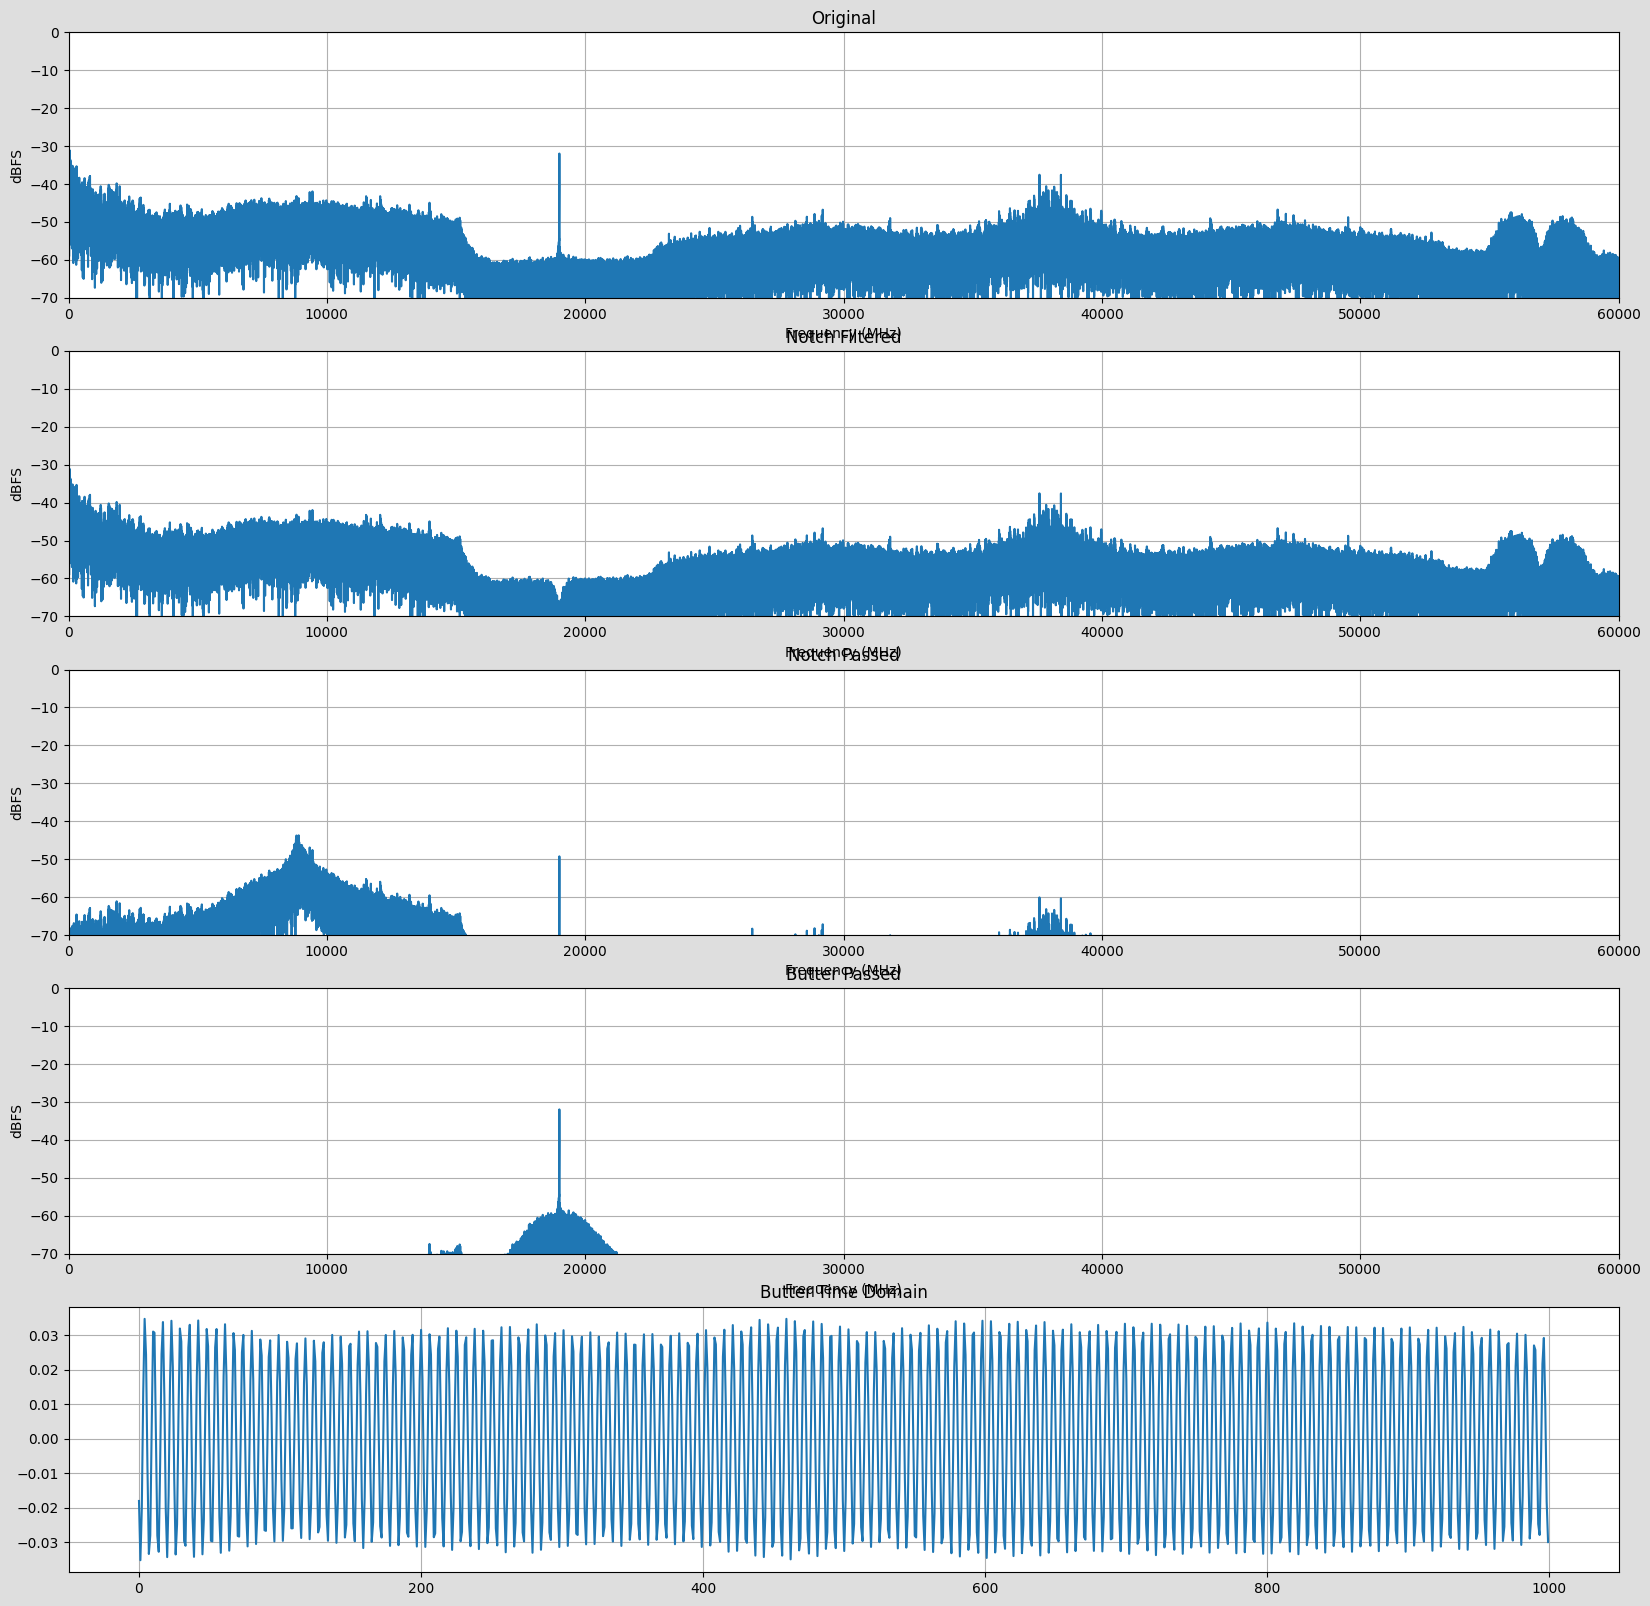

In [6]:
# Let's isolate that fuckin pilot!

from scipy import signal



global new_fs
global demod_filtered_resampled

f0 = 19e3  # Pilot Frequency
Q = 30.0  # Quality factor

# Design notch filter
filter_b, filter_a = signal.iirnotch(f0, Q, new_fs) # Notch filter
pass_b, pass_a = signal.iirpeak(f0, Q, fs) # Notch pass

butter_pass_b, butter_pass_a = build_butter_bandpass_filter( 18e3, 20e3, new_fs, order=3) # AGAIN order very finicky

fig, axes = plt.subplots( nrows=5, ncols=1, sharex=False, figsize=(20,20), facecolor='#DEDEDE' )

ax = axes[0]
ax.set_title( "Original" )
doRealPsd( ax, 0, fullscale, new_fs, demod_filtered_resampled )

ax = axes[1]
ax.set_title( "Notch Filtered" )
notch_filtered = apply_filter(filter_b, filter_a, demod_filtered_resampled)
doRealPsd( ax, 0, fullscale, new_fs, notch_filtered )

ax = axes[2]
ax.set_title( "Notch Passed" )
notch_passed = apply_filter(pass_b, pass_a, demod_filtered_resampled)
doRealPsd( ax, 0, fullscale, new_fs, notch_passed )

ax = axes[3]
ax.set_title( "Butter Passed" )
butter_passed = apply_filter(butter_pass_b, butter_pass_a, demod_filtered_resampled)
doRealPsd( ax, 0, fullscale, new_fs, butter_passed )

ax = axes[4]
ax.set_title( "Butter Time Domain" )
ax.plot( butter_passed[1000:2000] )

print( len(butter_passed) )
"""
Butter for the fucking win! With such a low order too, excellent.
"""

In [23]:
class PhaseDetector:
    def __init__(self) -> None:
        pass

    def proc( self, sigIn, sigOut ):
        return sigIn * sigOut


class LoopFilter:
    def __init__( self, K_i, K_p ) -> None:
        self.K_i = K_i
        self.K_p = K_p
        self.integrator = 0
    
    def proc( self, e_D ):
        self.integrator += self.K_i * e_D

        return self.K_p * e_D + self.integrator

class NumericallyControlledOscillator:
    def __init__( self, K_0 ) -> None:
        self.prevPhaseEstimate = 0
        self.K_0 = K_0

    def proc( self, e_F ):
        prev = self.prevPhaseEstimate
        new = prev + self.K_0 * e_F
        
        if new > 2*np.pi:
            new -= 2*np.pi
        self.prevPhaseEstimate = new
        
        return prev
    

class PhaseLockedLoop:
    def __init__( self, K_i, K_p, K_0, pll_f ) -> None:
        self.pd = PhaseDetector()
        self.lf = LoopFilter( K_i, K_p )
        self.nco = NumericallyControlledOscillator( K_0 )

        self.last_sin_out = 0
        self.last_phase_estimate = 0
        self.pll_f = pll_f

        self.theta = 0


    """
    The original code for this seemed pretty interested in delaying the output by one sample (or something along those lines)
    I took that all out and it appears to still work fine
    """
    def proc( self, in_, ):
        _e_D = self.pd.proc( in_, self.last_sin_out )

        #loop filter
        _e_F = self.lf.proc( _e_D )

        _phase_estimate = self.nco.proc( _e_F )        

        # The phase of our LO, which is additionally modified by the phase coming from our NCO.
        # IDK man, the NCO is a bit of a misnomer because its outputting a phase, not a signal
        self.theta += 2*np.pi*self.pll_f / new_fs # AHHHH MAKE THIS CONFIGURABLE BY GOD
        if self.theta > 2*np.pi:
            self.theta -= 2*np.pi

        # These were originally n+1
        _sin_out = -np.sin( self.theta + _phase_estimate )
        _cos_out = np.cos( self.theta + _phase_estimate )

        self.last_sin_out = _sin_out

        return _cos_out, _sin_out, _e_D
k = 1
N = 15
K_p = 0.2667
K_i = 0.0178
K_0 = 1

global butter_passed
global new_fs

e_D = [] #phase-error output
cos_out = [0]



pll = PhaseLockedLoop( K_i, K_p, K_0, 14e3 )
for n in range(len(butter_passed)):
    _cos_out, _sin_out, _e_D = pll.proc( butter_passed[n] )

    cos_out.append( _cos_out )
    e_D.append( _e_D )





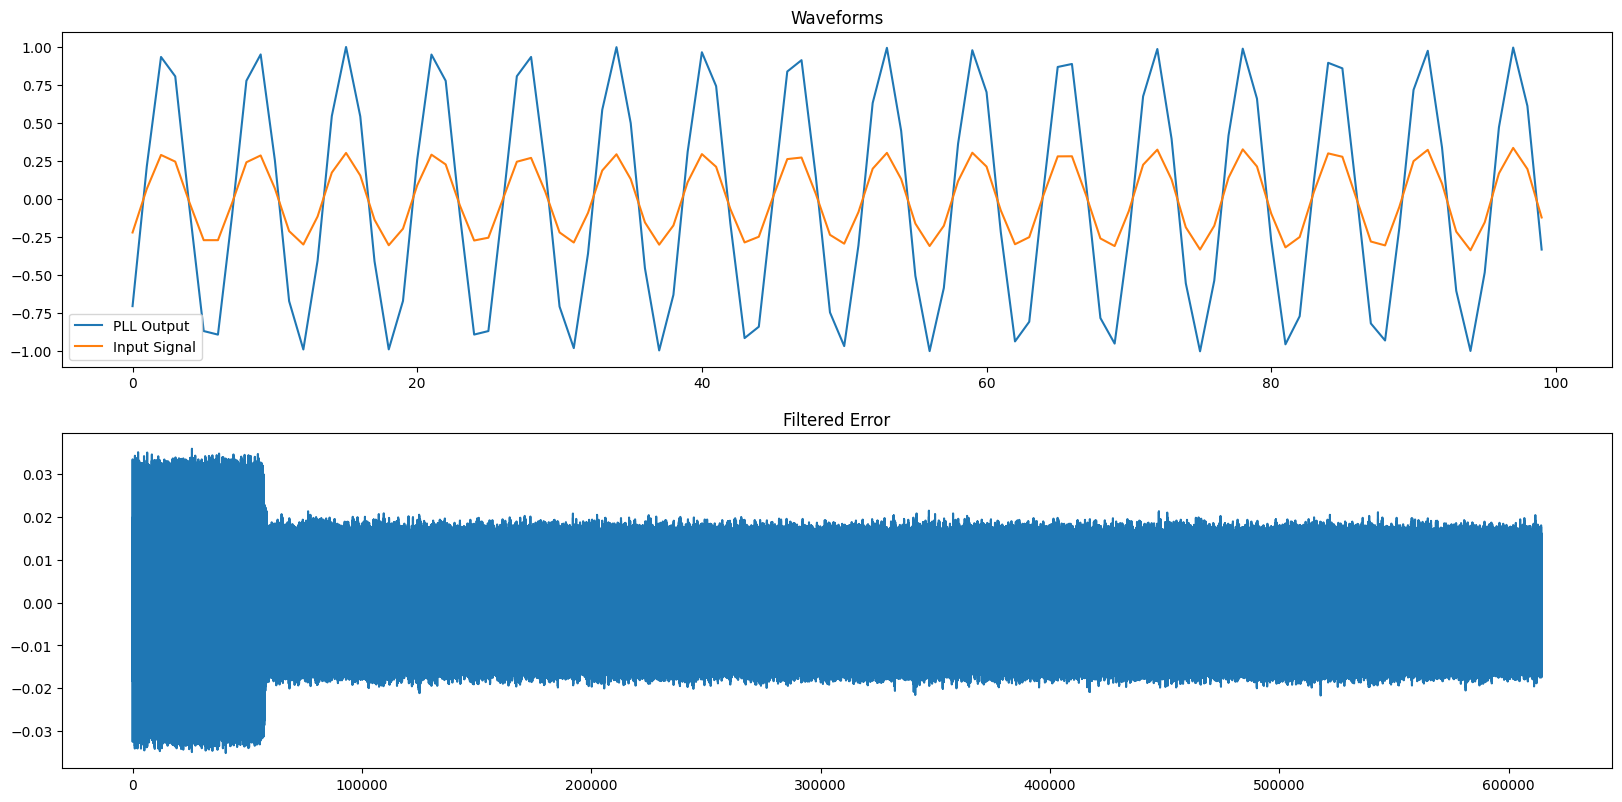

In [25]:
# Create a Figure
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

# Set up Axes
ax1 = fig.add_subplot(411)
nPlot = 100
ax1.plot(cos_out[290000:290000+nPlot], label='PLL Output')
plt.grid()
ax1.plot(butter_passed[290000:290000+nPlot]*10, label='Input Signal')
plt.legend()
ax1.set_title('Waveforms')

# Show the plot
#plt.show()

ax2 = fig.add_subplot(412)
ax2.plot( e_D )
plt.grid()
ax2.set_title('Filtered Error')
plt.show()